# 🔥 Fire Incident Analysis

In this section, we explore patterns in fire-related emergency calls. Understanding when, where, and how fires occur can help improve response strategies, public education, and resource allocation.

---

## 📊 Goals of This Analysis

- Identify **temporal patterns** in fire incidents (seasonality, time of day, etc.)
- Map **spatial hotspots** of fire calls across the city
- Analyze the **causes of fires** where known (e.g. cooking, electrical, arson)

---

## ⚠️ Why This Matters

- Fires are **low-frequency, high-impact** events — rare, but dangerous.
- Better prediction and prevention saves lives and reduces damage.
- Insight into fire types and response can inform **staffing, training, and equipment purchases**.





In [1]:
import pandas as pd
from shapely.geometry import Point
import geopandas as gpd

In [2]:
from dotenv import load_dotenv
import os
load_dotenv()
myfilepathcsv=os.getenv("Fires")
myfilepathgeojson=os.getenv("Maplines")

In [3]:
FireDF=pd.read_csv("C:/Users\danmc\OneDrive\Desktop\TCDSA\Structural_Fires.csv").query('longitude!=0')
geometry = [Point(xy) for xy in zip(FireDF.longitude, FireDF.latitude)]
gdf_points = gpd.GeoDataFrame(FireDF, geometry=geometry, crs="EPSG:4326")

maplines="C:/Users\danmc\OneDrive\Desktop\TCDSA\Minneapolis_Neighborhoods_-6491542160909536216.geojson"
gdf_polygons = gpd.read_file(maplines).to_crs("EPSG:4326")


In [4]:
joined = gpd.sjoin(gdf_polygons,
                   gdf_points[['propertyLoss','fireSpread','alarmDate','geometry']],
                   how="left", 
                   predicate="contains")
counts = joined.groupby(joined.index).size()
gdf_polygons["TotalFires"] = counts.reindex(gdf_polygons.index, fill_value=0)


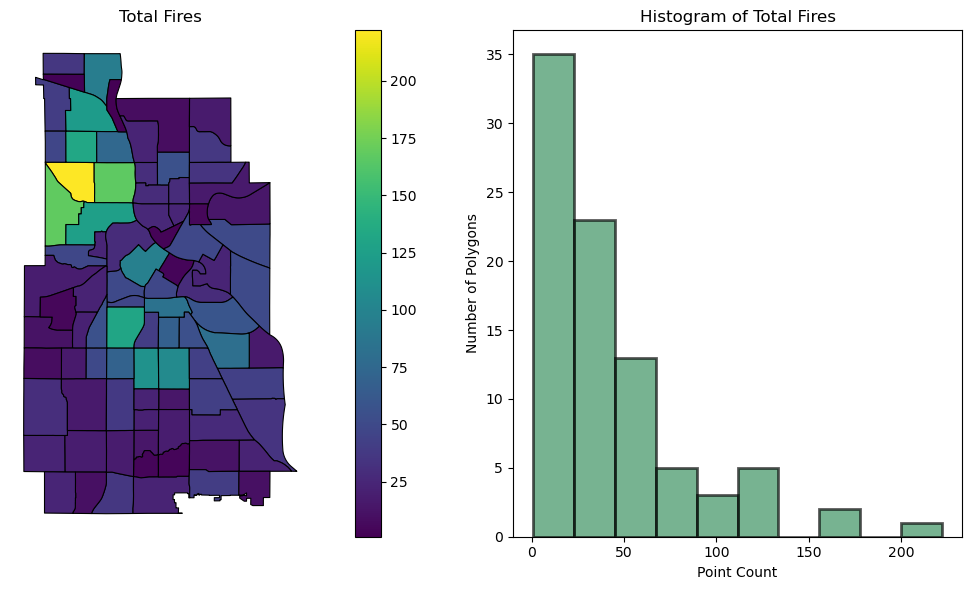

In [5]:
import matplotlib.pyplot as plt


fig, (ax_map, ax_hist) = plt.subplots(1, 2, figsize=(14, 6), gridspec_kw={'width_ratios': [2, 1]})

gdf_polygons.plot(
    column="TotalFires",
    cmap="viridis",
    linewidth=0.8,
    edgecolor='black',
    legend=True,
    ax=ax_map
)
ax_map.set_title("Total Fires")
ax_map.axis("off")

ax_hist.hist(gdf_polygons["TotalFires"], bins=10, color="seagreen", edgecolor="black",alpha=.65,lw=2)
ax_hist.set_title("Histogram of Total Fires")
ax_hist.set_xlabel("Point Count")
ax_hist.set_ylabel("Number of Polygons")

plt.tight_layout()
plt.show()


> 📌 **Note:** More recent data (through 2025) is available and can be incorporated in future analyses.  
> The 2009–2019 window was selected for the sake of expediency.


C:\Users\danmc\AppData\Local\Temp\ipykernel_23000\3183778945.py:1: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  pd.to_datetime(FireDF['alarmDate']).dt.to_period('M').value_counts().\


<Axes: title={'center': 'Monthly Fire Count Over The Years'}, xlabel='alarmDate'>

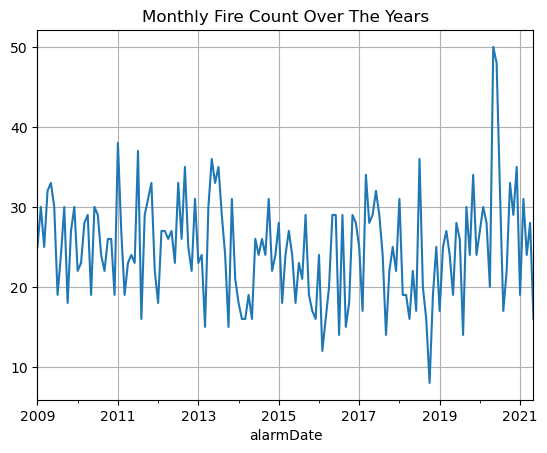

In [6]:
pd.to_datetime(FireDF['alarmDate']).dt.to_period('M').value_counts().\
    sort_index().clip(0,50).\
    plot(grid=True,title='Monthly Fire Count Over The Years')

C:\Users\danmc\AppData\Local\Temp\ipykernel_23000\2239999499.py:1: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  pd.to_datetime(FireDF['alarmDate']).dt.to_period('M').value_counts().\


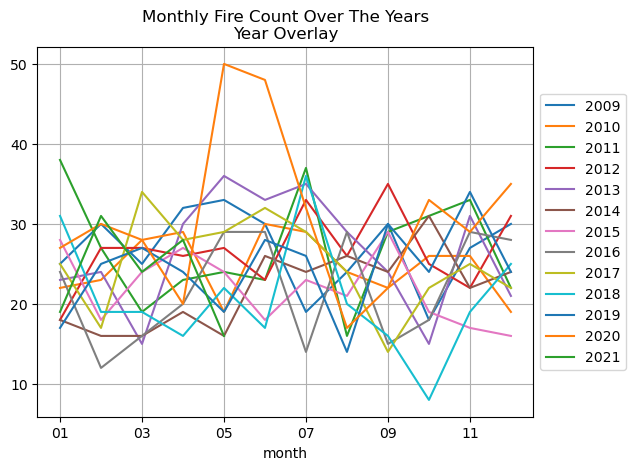

In [7]:
pd.to_datetime(FireDF['alarmDate']).dt.to_period('M').value_counts().\
    sort_index().clip(0,50).\
    reset_index().\
    assign(year=lambda x:x['alarmDate'].astype(str).str.split('-').str[0]).\
    assign(month=lambda x:x['alarmDate'].astype(str).str.split('-').str[1]).\
    pivot(index='month',columns='year',values='count').\
    plot(grid=True,title='Monthly Fire Count Over The Years\nYear Overlay').\
    legend(loc='center left', bbox_to_anchor=(1.0, 0.5))